In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

import joblib
import os
import yaml
from google.cloud import aiplatform as vertex_ai
from google.cloud import storage
from google.cloud import bigquery

In [2]:
plt.rcParams['font.family'] = 'DejaVu Sans'

In [3]:
# Load configuration
CONFIG_PATH = "../configs/config.yaml"
with open(CONFIG_PATH, 'r') as config_file:
    config = yaml.safe_load(config_file)

# Paths from configuration
PROJECT_ID = config['gcp']['project_id']
LOCATION = config['gcp']['location']
TENSORBOARD_NAME = f"projects/{PROJECT_ID}/locations/{LOCATION}/tensorboards/149744687610068992"


In [4]:
# Set up experiment tracking
vertex_ai.init(
    project=PROJECT_ID,
    location=LOCATION,
    staging_bucket="gs://experiment_tracking_bucket",
    experiment="retail-experiment-autolog",
    experiment_tensorboard=vertex_ai.Tensorboard(TENSORBOARD_NAME)
)

In [5]:
# Set up BigQuery client
client = bigquery.Client(project="mlops-retail-quant")

# Query the data from BigQuery
query = """
SELECT * FROM `mlops-retail-quant.retail_dataset.raw_data_table`
"""
df = client.query(query).to_dataframe()

# Display the dataframe
df.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536414,22139,None,56,2010-12-01 11:52:00+00:00,0.0,<NA>,United Kingdom
1,536545,21134,None,1,2010-12-01 14:32:00+00:00,0.0,<NA>,United Kingdom
2,536546,22145,None,1,2010-12-01 14:33:00+00:00,0.0,<NA>,United Kingdom
3,536547,37509,None,1,2010-12-01 14:33:00+00:00,0.0,<NA>,United Kingdom
4,536549,85226A,None,1,2010-12-01 14:34:00+00:00,0.0,<NA>,United Kingdom


In [6]:
df.shape

(541909, 8)

In [7]:
df.dtypes

invoice_no                   object
stock_code                   object
description                  object
quantity                      Int64
invoice_date    datetime64[us, UTC]
unit_price                  float64
customer_id                   Int64
country                      object
dtype: object

In [8]:
print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending = False))

customer_id    135080
description      1454
dtype: int64


In [9]:
df.duplicated().sum()

5268

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   invoice_no    541909 non-null  object             
 1   stock_code    541909 non-null  object             
 2   description   540455 non-null  object             
 3   quantity      541909 non-null  Int64              
 4   invoice_date  541909 non-null  datetime64[us, UTC]
 5   unit_price    541909 non-null  float64            
 6   customer_id   406829 non-null  Int64              
 7   country       541909 non-null  object             
dtypes: Int64(2), datetime64[us, UTC](1), float64(1), object(4)
memory usage: 34.1+ MB


### Data Cleaning

In [11]:
#Removing NaN's in Customer ID
print("Shape of df before removing NaN's CustomerID",df.shape)
df_v2 = df.dropna(subset="customer_id",axis=0)
print("Shape of df after removing NaN's CustomerID",df_v2.shape)

Shape of df before removing NaN's CustomerID (541909, 8)
Shape of df after removing NaN's CustomerID (406829, 8)


In [12]:
print("Missing values in each column after cleaning customerID :\n",df_v2.isnull().sum())

Missing values in each column after cleaning customerID :
 invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64


In [13]:
# after reading invoice_no starts with the 'c' means cancelled transaction
df_v3 = df_v2[~df_v2.invoice_no.str.contains('C',na=False)]
print("Dataset is free from cancelled products information")

Dataset is free from cancelled products information


In [14]:
# Removing duplicates (Values in all columns are identical)
print("Number of duplicates before cleaning:",df_v3.duplicated().sum())
df_v4 = df_v3.drop_duplicates(keep="first")
print("Number of duplicates after cleaning:",df_v4.duplicated().sum())

Number of duplicates before cleaning: 5192
Number of duplicates after cleaning: 0


In [15]:
print("Negative value in Quantity is:",(df_v4.quantity<0).sum())
print("Negative value in Unit Price is:",(df_v4.unit_price<0).sum())

Negative value in Quantity is: 0
Negative value in Unit Price is: 0


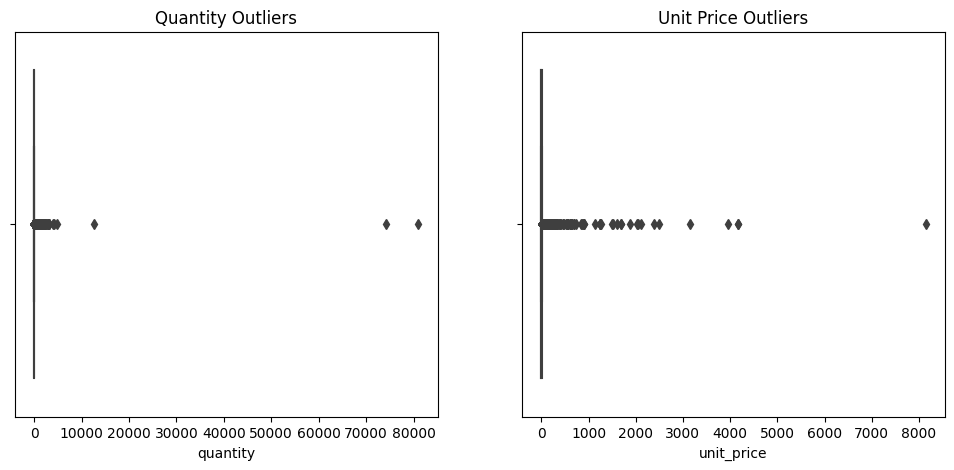

In [16]:
# Boxplot for quantity and unit price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_v4['quantity'])
plt.title('Quantity Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_v4['unit_price'])
plt.title('Unit Price Outliers')

plt.show()

In [17]:
# Define function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from quantity and unit price
df_v5 = remove_outliers(df_v4, 'quantity')
df_v6 = remove_outliers(df_v5, 'unit_price')


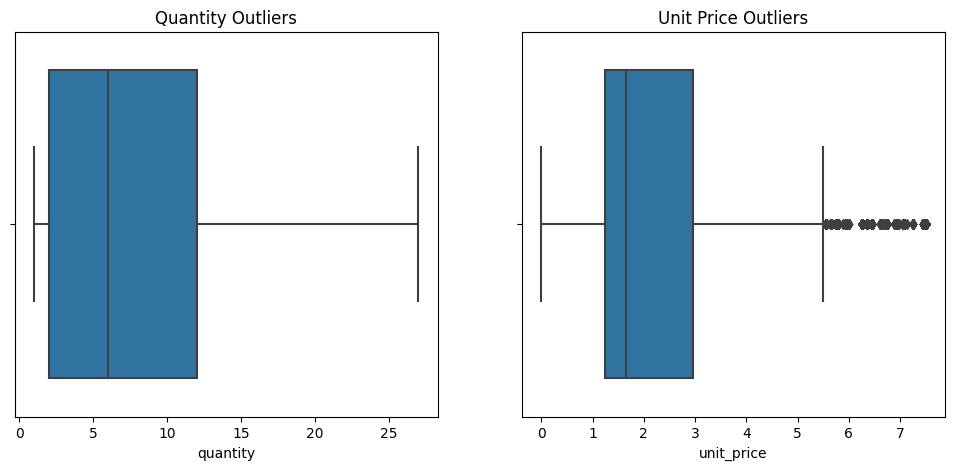

In [18]:
# Boxplot for quantity and unit price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_v6['quantity'])
plt.title('Quantity Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_v6['unit_price'])
plt.title('Unit Price Outliers')

plt.show()

In [19]:
df_v6.shape

(333265, 8)

### RFMT


In [20]:
df_v7 = df_v6.copy()
df_v7['total'] = df_v6['quantity'] * df_v6['unit_price']

In [21]:
latest_date = df_v7['invoice_date'].max()

# Create RFM features and Shopping Cycle
RFM = df_v7.groupby('customer_id').agg(
    Recency=('invoice_date', lambda x: (latest_date - x.max()).days),
    Frequency=('invoice_no', 'nunique'),
    Monetary=('total', 'sum'),
    Tenure=('invoice_date', lambda x: (x.max() - x.min()).days)
)

# Calculate Interpurchase Time
RFM['Interpurchase_Time'] = RFM['Tenure'] / RFM['Frequency']

# Create RFMT dataframe with required features
RFMT = RFM[['Recency', 'Frequency', 'Monetary', 'Interpurchase_Time']]


RFMT.head()

,Recency,Frequency,Monetary,Interpurchase_Time
customer_id,,,,
12347,1,7,3314.73,52.142857
12348,248,3,90.2,36.333333
12349,18,1,999.15,0.000000
12350,309,1,294.4,0.000000
12352,35,7,1130.94,37.142857


### Customer Segmentation

In [22]:
# Standardizing the RFMT data
scaler = StandardScaler()
rfmt_scaled = scaler.fit_transform(RFMT)


In [63]:
db1 = DBSCAN(eps=0.3, min_samples=10).fit(rfmt_scaled)
labels1 = db1.labels_

In [64]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_1 = len(set(labels1)) - (1 if -1 in labels1 else 0)
n_noise_1 = list(labels1).count(-1)

print("Estimated number of clusters: %d" % n_clusters_1)
print("Estimated number of noise points: %d" % n_noise_1)

Estimated number of clusters: 2
Estimated number of noise points: 294


In [67]:
print(f"Silhouette Coefficient: {metrics.silhouette_score(rfmt_scaled, labels1):.3f}")

Silhouette Coefficient: 0.165


In [38]:
db2 = DBSCAN(eps=0.1, min_samples=50).fit(rfmt_scaled)
labels2 = db2.labels_

n_clusters_2 = len(set(labels2)) - (1 if -1 in labels2 else 0)
n_noise_2 = list(labels2).count(-1)

print("Estimated number of clusters: %d" % n_clusters_2)
print("Estimated number of noise points: %d" % n_noise_2)

Estimated number of clusters: 5
Estimated number of noise points: 3098


In [45]:
print(f"Silhouette Coefficient: {metrics.silhouette_score(rfmt_scaled, labels2):.3f}")

Silhouette Coefficient: 0.043


In [40]:
RFMT['Cluster'] = db2.fit_predict(rfmt_scaled)

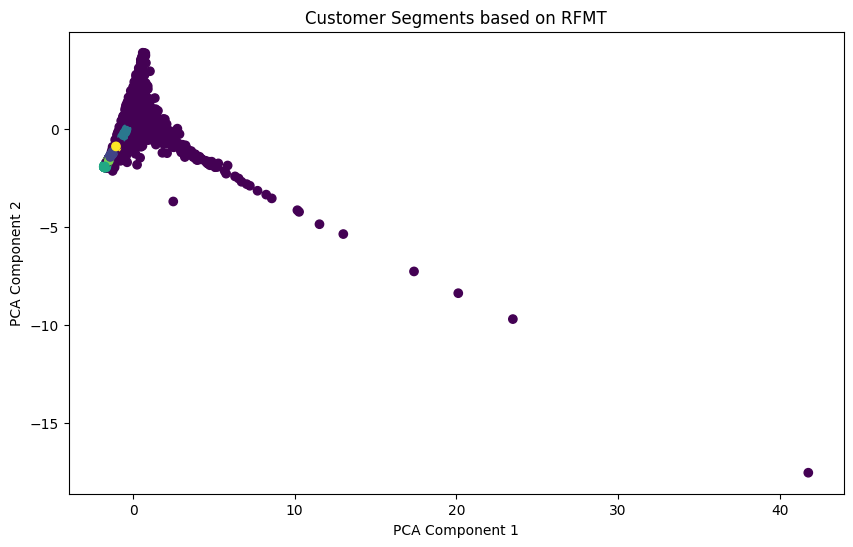

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfmt_pca = pca.fit_transform(rfmt_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(rfmt_pca[:, 0], rfmt_pca[:, 1], c=RFMT['Cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments based on RFMT')
plt.show()


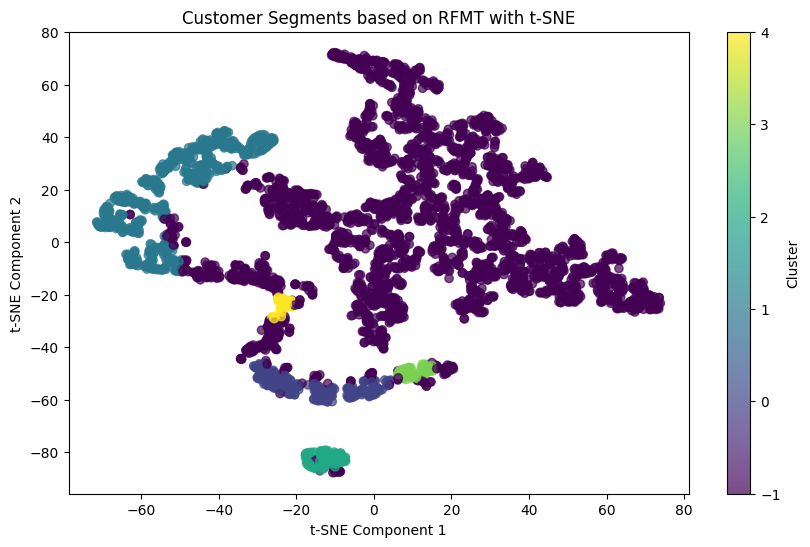

In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
rfmt_tsne = tsne.fit_transform(rfmt_scaled)

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(rfmt_tsne[:, 0], rfmt_tsne[:, 1], c=RFMT['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Customer Segments based on RFMT with t-SNE')
plt.colorbar(label='Cluster')
plt.show()


In [72]:
from datetime import datetime
today = datetime.today().strftime('%Y%m%d')

metrics_ = {}
params = {}

for k in range(1, 6):
    with vertex_ai.start_run(run=f"dbscan-{today}-run{k}"):
        db = DBSCAN(eps=k/10, min_samples=50).fit(rfmt_scaled)
        labels = db.labels_
        silhouette_avg = metrics.silhouette_score(rfmt_scaled, labels)
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        metrics_["silhouette_score"] = silhouette_avg
        metrics_["noise"] = n_noise_
        
        params["n_clusters"] = n_clusters_
        

        vertex_ai.log_metrics(metrics_) # Log metrics
        vertex_ai.log_params(params) # Log model parameters  

Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-dbscan-20241013-run1 to Experiment: retail-experiment-autolog


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-dbscan-20241013-run2 to Experiment: retail-experiment-autolog


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-dbscan-20241013-run3 to Experiment: retail-experiment-autolog


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-dbscan-20241013-run4 to Experiment: retail-experiment-autolog


Associating projects/456146517905/locations/europe-central2/metadataStores/default/contexts/retail-experiment-autolog-dbscan-20241013-run5 to Experiment: retail-experiment-autolog


In [71]:
tensorboard_run_artifact = vertex_ai.metadata.artifact.Artifact(artifact_name=f"retail-experiment-autolog-dbscan-20241013-run1-tb-run")
tensorboard_run_resource = vertex_ai.TensorboardRun(tensorboard_run_artifact.metadata["resourceName"])
tensorboard_run_resource.delete()
tensorboard_run_artifact.delete()

Deleting TensorboardRun : projects/456146517905/locations/europe-central2/tensorboards/149744687610068992/experiments/retail-experiment-autolog/runs/dbscan-20241013-run1
TensorboardRun deleted. . Resource name: projects/456146517905/locations/europe-central2/tensorboards/149744687610068992/experiments/retail-experiment-autolog/runs/dbscan-20241013-run1
Deleting TensorboardRun resource: projects/456146517905/locations/europe-central2/tensorboards/149744687610068992/experiments/retail-experiment-autolog/runs/dbscan-20241013-run1
Delete TensorboardRun backing LRO: projects/456146517905/locations/europe-central2/tensorboards/149744687610068992/experiments/retail-experiment-autolog/operations/3637128389589991424
TensorboardRun resource projects/456146517905/locations/europe-central2/tensorboards/149744687610068992/experiments/retail-experiment-autolog/runs/dbscan-20241013-run1 deleted.
Deleting Artifact : projects/456146517905/locations/europe-central2/metadataStores/default/artifacts/retai

In [73]:
cluster_analysis = RFMT.groupby('Cluster').mean()
print(cluster_analysis)

            Recency  Frequency     Monetary  Interpurchase_Time
Cluster                                                        
-1        72.194319    5.08102  1317.527135           41.612336
 0       260.036437    1.00000   169.552308            0.000000
 1        44.057692    1.00000   219.387181            0.000000
 2       364.778846    1.00000   168.602115            0.000000
 3       312.044776    1.00000   193.526716            0.000000
 4       176.365385    1.00000   163.445962            0.000000


In [75]:
# Save the Models
joblib.dump(scaler, '/home/jupyter/models/dbscan/scaler.pkl')
joblib.dump(db, '/home/jupyter/models/dbscan/model.pkl')

['/home/jupyter/models/dbscan/model.pkl']

In [76]:
def upload_to_gcs(bucket_name, source_file_name, dest_file_name):
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(dest_file_name)
    blob.upload_from_filename(source_file_name)
    print(f"File {source_file_name} uploaded to {bucket_name}.")

BUCKET_NAME = "dbscan_model_bucket"
DEST_FILE_NAME = "model.pkl"
SOURCE_FILE_NAME = "/home/jupyter/models/dbscan/model.pkl"

upload_to_gcs(BUCKET_NAME, SOURCE_FILE_NAME, DEST_FILE_NAME)

File /home/jupyter/models/dbscan/model.pkl uploaded to dbscan_model_bucket.


In [77]:
# Upload the kmeans model to Model Registry
dbscan_model_artifact_path = "/home/jupyter/models/dbscan/"
dbscan_display_name = "DBSCAN_Model"

dbscan_vertex_model = vertex_ai.Model.upload(
    display_name=dbscan_display_name,
    artifact_uri=os.path.join(os.getcwd(), dbscan_model_artifact_path),
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest",
)

print(f"DBSCAN Model uploaded to Vertex AI: {dbscan_vertex_model.resource_name}")

Creating Model
Create Model backing LRO: projects/456146517905/locations/europe-central2/models/8158253132795609088/operations/529644646704349184
Model created. Resource name: projects/456146517905/locations/europe-central2/models/8158253132795609088@1
To use this Model in another session:
model = aiplatform.Model('projects/456146517905/locations/europe-central2/models/8158253132795609088@1')
DBSCAN Model uploaded to Vertex AI: projects/456146517905/locations/europe-central2/models/8158253132795609088
